<center><font size = "10"> Week 3 - Ion Channels <center>
<center><font size = "8">Tutorial 04: NMODL <center>

# Implementing ion channel models
<font size="5">
Custom ion channel models can be implemented in NEURON using NMODL.

During this tutorial and subsequent exercises, you may want to keep the following webpages open:
 - https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl.html
 - https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl2.html
 - https://neuronline.github.io/compneuro/software/neuron/nmodl/
 
NMODL is a domain-specific language that allows the specification of models such as ion channels and synapses.

We are going to implement a model of a voltage-dependent calcium channel, based on this paper: https://pubmed.ncbi.nlm.nih.gov/8229187/

NMODL code does not run in a Jupyter notebook, the ion channel model is located in Ca.mod which is compiled when we run `nrnivmodl`


<font size="5">
Some ion channels are closed at particular membrane potentials (voltage-sensitive or voltage-dependent ion channels). They open when the membrane potential changes, but they do not do so instantaneously.
This slow opening is what gives the characteristic Activation curves you see in the experimental data.

    
Additionally, some ion channels which open at a particular membrane potential will close again after a short time. This is the inactivation curve, a process, like activation, driven by voltage, but generally slower and active at different potentials.
    
The voltage-dependent calcium channel we model here is both voltage-activated and inactivated.

    
This ion channel model describes the current through the calcium channels $I_{Ca}$ as 

$ I_{Ca} = g_{Ca} \times (v - E_{Ca}) $

where $g_{Ca} $ is the ion channel's conductance, $v$ is the membrane potential, and $E_{Ca}$ is the reversal potential of calcium (the potential difference at which the flow of ions due to both the potential difference itself and the concentration gradient,  would be equal, and conductance hence 0).

The calcium conductance $g_{Ca}$ is further determined by:

$ g_{Ca} = m^2 h \bar{g_{Ca}}$

Where $\bar{g_{Ca}}$ is the maximum conductance, a parameter of the model, and m and h are abstract variables that together ($m^2h$) describe the opening probablity of the ion channel at a given point in time.

The time evolution of $m$ and $h$ is governed by the differential equations:

$ m' = \frac{m_{inf} - m}{\tau_{m}} $

$ h' = \frac{h_{inf} - h}{\tau_{h}}$


That is to say, they decay exponentially towards $m_{inf}$ and $h_{inf}$ with a decay time constant of $\tau_m$ and $\tau_h$ respectively.

The values they decay to, and how fast they decay also vary with voltage. This is where the original model gets more complicated. For the purposes of this tutorial we have replaced the real equations with straighforward sigmoids.

$m_{inf} = \frac{1}{1 + e^{a_1 - v}}$

$\tau_{m} = \frac{a_2}{1 + e^{a_3 - v}}$
    
$h_{inf} = 1 - \frac{1}{1 + e^{b_1 - v}}$
    
$\tau_{h} = \frac{b_2}{1 + e^{b_3 - v}}$
    
Where $a_1$, $a_2$, $a_3$, $b_1$, $b_2$, and $b_3$ are constants.

## NEURON block

This part declares the mechanism name (`Ca`), the ion(s) used and what information about these ion(s) the model acts on.
Note the "minimalistic" naming convention.

 - `eca` : Calcium reversal potential ($E_{Ca}$). Generally determined automatically from the Nernst equation (although it can be altered manually), this variable is built in to NEURON
 - `ica`: Transmembrane calcium current ($I_{Ca}$). this variable is built-in to NEURON
 - `gCabar` is the maximal calcium conductance per unit surface area and `gCa` is the actual calcium conductance per unit surface area. This variable is defined by this model.
 
The variables declared as `RANGE` variables vary continuously throughout the compartment (as opposed to having simply one value in the compartment).
In order to be set with the python API, parameters need to be listed here. Any parameters declared but not listed in `NEURON` will be unmodifiable outside of the modfile.



## PARAMETER block

The parameters block contains variables that are not modified by the model.
They can be set by the user, but should have default values provided in the modfile itself.

In our case, that is the maximum conductance, and the magic constants we just made up.

## STATE block

The state variables that will be described by differential equations in the DERIVATIVE block.

m and h are variables describing the activation and inactivation of the ion channels.
They do not directly translate to any physical properties, but $m^2 h$ represents the opening probability of the ion channels.



## ASSIGNED block

These variables can vary with time but are updated directly, instead of having their values solved from differential equations.

    - v: membrane potential (built-in variable: do not alter its value directly!)
    - eca: calcium reversal potential (built-in variable: do not alter its value directly!)
    - ica: calcium current (built-in variable: do not alter its value directly!)
    - gCa: conductance of ion channels (at a given point in time)
    - mInf: the value towards which m decays at a given point in time
    - mTau: the time constant of decay of m at a given point in time
    - hInf: the value towards which h decays at a given point in time
    - hTau: the time constent of decay of h at a given point in time


## BREAKPOINT

The BREAKPOINT block is the meat of the simulation: this is where time is advanced and the differential equations are solved to arrive at the values of the states and relevant conductances and currents.

The SOLVE statement tells us which differential equations to solve (we will declare them in the `DERIVATIVE` block below) and which method to use (e.g. euler, cnexp).
After solving for m and h, we apply them to the maximum conductance to get the current conductance, and subsequently translate that conductance into the calium current `ica` using `v` and `eca`, the membrane potential and calcium reversal potential respectively.

## DERIVATIVE states

The DERIVATIVE block declares a set of differential equations to solve. 
We write our equations here and call the set `states`

Note the call `rates()`: this is a procedure determines the values of `mInf`, `hInf`, `mTau`, and `hTau` which will declare later with a `PROCEDURE` block.

## INITIAL block

The initial block is called at the start of the simulation and sets the initial values of the states.


## PROCEDURE blocks

A PROCEDURE block defines a procedure which can be re-used at any point in DERIVATIVE, BREAKPOINT, or INITIAL blocks.

Here we calculate `mInf`, `hInf`, `mTau` and `hTau` from membrane potential.

We turn off unit checking because all values used are dimensionless.

## Running the model

We compile the .mod file and insert the mechanism into a section using `.insert("Ca")` (remember that we declared Ca as the mechanism name above).
Then we can run simulations and see how our model behaves.


In [1]:
# This will compile the mechanisms inside the MOD files (and create a new folder x86_64/special).
! nrnivmodl

/Users/wesleymonteith/miniconda3/envs/biophysics/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/usr/bin/xcrun
/Users/wesleymonteith/code/nx-450-computational-neuroscience-biophysics/Week 3
Mod files: "./Ca.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created x86_64/special


In [2]:
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

h.load_file('stdrun.hoc')

--No graphics will be displayed.


1.0

In [3]:
# Create a section 
soma = h.Section()
soma.L = 18.0     # length (µm)
soma.diam = 18.0  # diameter (µm)
soma.Ra = 123.0   # axial resistivity (Ω*cm)
soma.nseg = 1
soma.cm = 20
soma.insert('pas') # passive leakage

soma.insert("Ca")


__nrnsec_0x7fbc6012c000

### Accessing parameters

Parameters that were declared in the NEURON block can be accessed and set: in our case, `gCabar`.
Since it is a RANGE variable it is only defined on the segments of the Section, not the Section itself.

It can be accessed either with `Segment.<varname>_<suffix>` or `Segment.<suffix>.<varname>`.

In [4]:

for seg in soma:
    print(seg.Ca.gCabar)
    print(seg.gCabar_Ca)

1e-05
1e-05


In [5]:

# Inject a current step into the soma
stim = h.IClamp(soma(0.5))         # Place a stimulation electrode in the middle of the soma
stim.delay = 100   # stim delay (ms)
stim.amp = 0.6   # stim amplitude (nA)
stim.dur = 500     # stim duration (ms)

In [6]:
# soma is a section, soma(0.5) refers to a segment halfway across the soma, ._ref_ica is a reference to the variable ica at that segment
# using Vector.record allows us to measure this value from the simulations.

time = h.Vector()
time.record(h._ref_t) 
calcium_current = h.Vector()
calcium_current.record(soma(0.5)._ref_ica)
soma_voltage = h.Vector()
soma_voltage.record(soma(0.5)._ref_v)

Vector[2]

In [7]:
# Initialize and run a simulation
h.finitialize(-70)    # initial voltage 
h.continuerun(700)    # total recording duration

0.0

Text(0.5, 0, 'time (ms)')

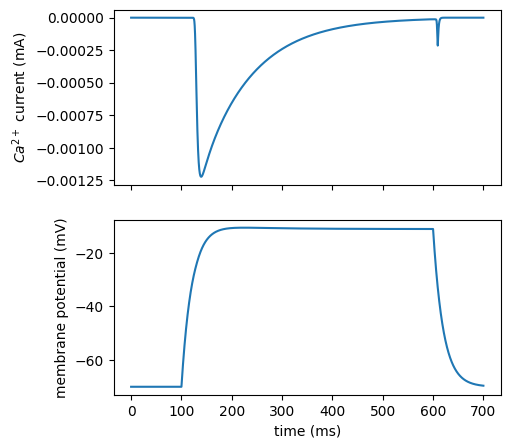

In [8]:
plot_ca = np.array(calcium_current)
plot_v = np.array(soma_voltage)
plot_t = np.array(time)
fig, axes = plt.subplots(2, figsize=(5, 5), sharex=True)
axes[0].plot(plot_t, plot_ca)
axes[0].set_ylabel("$Ca^{2+}$ current (mA)")
axes[1].plot(plot_t, plot_v)
axes[1].set_ylabel("membrane potential (mV)")
axes[1].set_xlabel("time (ms)")


100%|██████████| 100/100 [00:06<00:00, 15.57it/s]


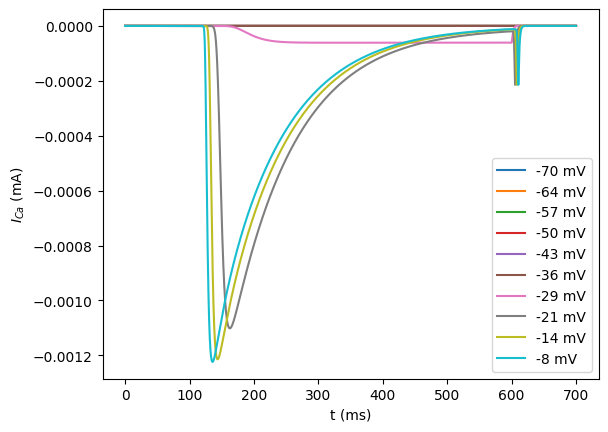

(0.0, 1.0)

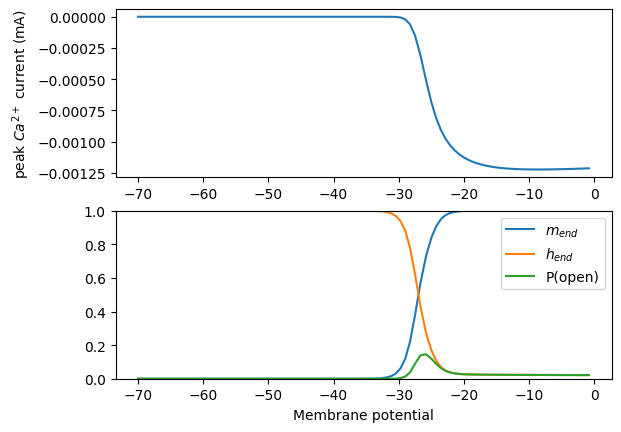

In [9]:

from tqdm import tqdm
voltages = []
currents = []
# for hInf and Inf we record _ref_h and _ref_m, because only states can be recorded.
# we get hInf and mInf by getting the 
hInf = h.Vector()
hInf.record(soma(0.5).Ca._ref_h)
mInf = h.Vector()
mInf.record(soma(0.5).Ca._ref_m)
minfs = []
hinfs = []
i = 0
for a in tqdm(np.linspace(0, 0.7, 100)):
    stim.amp = a
    h.finitialize(-70)    # initial voltage 
    h.continuerun(700)    # total recording duration
    voltages.append(np.max(np.array(soma_voltage)))
    currents.append(np.min(np.array(calcium_current)))
    minfs.append(np.array(mInf)[20000])
    hinfs.append(np.array(hInf)[20000])
    if i % 10 == 0:
        plt.plot(time, calcium_current, label=f"{int(np.floor(voltages[-1]))} mV")

    i += 1
plt.legend()  
plt.xlabel("t (ms)")
plt.ylabel("$I_{Ca}$ (mA)")
plt.show()

minfs = np.array(minfs)
hinfs = np.array(hinfs)

f, a = plt.subplots(2, 1)
a[0].plot(voltages, currents)
a[1].set_xlabel("Membrane potential")
a[0].set_ylabel("peak $Ca^{2+}$ current (mA)")
a[1].plot(voltages, minfs, label="$m_{end}$")
a[1].plot(voltages, hinfs, label="$h_{end}$")
a[1].plot(voltages, minfs*minfs*hinfs, label="P(open)")
plt.legend()
a[1].set_ylim(0, 1)

